In [1]:
## import all the packages you need 
import psycopg2
import pandas as pd
from getpass import getpass
from sqlalchemy import create_engine
import seaborn as sns
from datetime import date, datetime
from dateutil.relativedelta import relativedelta
import warnings
from matplotlib import pyplot as plt
warnings.filterwarnings('ignore')

In [64]:
import numpy as np

In [5]:
# Enter database connection parameters
# Could also store and read these as environment variables,
# but best practice is to never include credentials directly
# in version control
hostname = input("Enter server hostname: ")
username = input("Enter username: ")
password = getpass("Enter password: ")
database_name = input("Enter database name: ")

Enter server hostname: spinup-db001ec7.cluster-c9ukc6s0rmbg.us-east-1.rds.amazonaws.com
Enter username: introml568
Enter password: ········
Enter database name: synthea-omop


In [6]:
# Connect using SQL Alchemy to support pandas mapping
alchemy_engine = create_engine(f"postgresql+psycopg2://{username}:{password}@{hostname}/{database_name}",  pool_recycle=3600)
db_connection = alchemy_engine.connect();

In [7]:
# Read in SQL tables through Pandas: Person and Visit 
omop_person = pd.read_sql("select * from omop.person", db_connection);
omop_visit = pd.read_sql("select * from omop.visit_occurrence", db_connection);

In [8]:
omop_death = pd.read_sql("select * from omop.death", db_connection);

In [9]:
omop_death.head()

,person_id,death_date,death_datetime,death_type_concept_id,cause_concept_id,cause_source_value,cause_source_concept_id
0,9777,2013-11-13,2013-11-13,38003566,4329847,22298006,4329847
1,9849,2018-01-28,2018-01-28,38003566,4115276,254637007,4115276
2,1769,2009-12-30,2009-12-30,38003566,4329847,22298006,4329847
3,4697,1992-01-08,1992-01-08,38003566,381316,230690007,381316
4,3955,1973-01-03,1973-01-03,38003566,4329847,22298006,4329847


# Developping Cohort

### person and visit data

In [10]:
#cols needed from patient
person_cols = ['person_id', 'gender_concept_id', 'gender_source_value','birth_datetime', 'race_source_value', 'ethnicity_source_value']
ps = omop_person[person_cols]
ps.head()

,person_id,gender_concept_id,gender_source_value,birth_datetime,race_source_value,ethnicity_source_value
0,1,8532,F,1927-10-03,white,nonhispanic
1,2,8507,M,1979-06-30,white,nonhispanic
2,3,8532,F,1930-05-21,white,nonhispanic
3,4,8507,M,1921-10-05,white,hispanic
4,5,8507,M,1936-08-05,white,nonhispanic


In [11]:
#define a function to find a person's current age
def person_age(birthdate):
    """
    defines age based on current date
    """
    difference_in_years = relativedelta(datetime.now(), birthdate).years
    return difference_in_years

In [12]:
#get the current age 
ps['current_age'] = ps.birth_datetime.apply(person_age)
ps.head()

,person_id,gender_concept_id,gender_source_value,birth_datetime,race_source_value,ethnicity_source_value,current_age
0,1,8532,F,1927-10-03,white,nonhispanic,95
1,2,8507,M,1979-06-30,white,nonhispanic,43
2,3,8532,F,1930-05-21,white,nonhispanic,92
3,4,8507,M,1921-10-05,white,hispanic,101
4,5,8507,M,1936-08-05,white,nonhispanic,86


In [13]:
#cols needed from visit table 
visit_cols = ['visit_occurrence_id', 'person_id', 'visit_concept_id','visit_start_date', 'visit_start_datetime', 
              'visit_end_date', 'visit_end_datetime', 'visit_type_concept_id']
vs = omop_visit[visit_cols]
vs.head()

,visit_occurrence_id,person_id,visit_concept_id,visit_start_date,visit_start_datetime,visit_end_date,visit_end_datetime,visit_type_concept_id
0,63,1,9202,1928-05-07,1928-05-07,1928-05-07,1928-05-07,44818517
1,53,1,9202,1928-05-18,1928-05-18,1928-05-18,1928-05-18,44818517
2,73,1,9202,1945-11-26,1945-11-26,1945-11-26,1945-11-26,44818517
3,48,1,9202,1946-12-02,1946-12-02,1946-12-02,1946-12-02,44818517
4,55,1,9202,1947-12-08,1947-12-08,1947-12-08,1947-12-08,44818517


In [14]:
# calculated and added a new variable visit_length_hours
vs['visit_length'] = vs.apply(lambda x: relativedelta(x['visit_end_datetime'], x['visit_start_datetime']).hours, axis=1)
vs.head()

,visit_occurrence_id,person_id,visit_concept_id,visit_start_date,visit_start_datetime,visit_end_date,visit_end_datetime,visit_type_concept_id,visit_length
0,63,1,9202,1928-05-07,1928-05-07,1928-05-07,1928-05-07,44818517,0
1,53,1,9202,1928-05-18,1928-05-18,1928-05-18,1928-05-18,44818517,0
2,73,1,9202,1945-11-26,1945-11-26,1945-11-26,1945-11-26,44818517,0
3,48,1,9202,1946-12-02,1946-12-02,1946-12-02,1946-12-02,44818517,0
4,55,1,9202,1947-12-08,1947-12-08,1947-12-08,1947-12-08,44818517,0


In [15]:
#merge ps and vs
df = pd.merge(ps, vs, on='person_id', how="inner")

In [16]:
#add visit age
df['visit_age'] = df.apply(lambda x: relativedelta(x['visit_start_datetime'], x['birth_datetime']).years, axis=1)
df.head()

,person_id,gender_concept_id,gender_source_value,birth_datetime,race_source_value,ethnicity_source_value,current_age,visit_occurrence_id,visit_concept_id,visit_start_date,visit_start_datetime,visit_end_date,visit_end_datetime,visit_type_concept_id,visit_length,visit_age
0,1,8532,F,1927-10-03,white,nonhispanic,95,63,9202,1928-05-07,1928-05-07,1928-05-07,1928-05-07,44818517,0,0
1,1,8532,F,1927-10-03,white,nonhispanic,95,53,9202,1928-05-18,1928-05-18,1928-05-18,1928-05-18,44818517,0,0
2,1,8532,F,1927-10-03,white,nonhispanic,95,73,9202,1945-11-26,1945-11-26,1945-11-26,1945-11-26,44818517,0,18
3,1,8532,F,1927-10-03,white,nonhispanic,95,48,9202,1946-12-02,1946-12-02,1946-12-02,1946-12-02,44818517,0,19
4,1,8532,F,1927-10-03,white,nonhispanic,95,55,9202,1947-12-08,1947-12-08,1947-12-08,1947-12-08,44818517,0,20


### measurement and condition information(merge with concept table)

In [17]:
# read in a new table for measurement
omop_meas = pd.read_sql("select * from omop.measurement", db_connection);

In [18]:
omop_meas.head()

,measurement_id,person_id,measurement_concept_id,measurement_date,measurement_datetime,measurement_time,measurement_type_concept_id,operator_concept_id,value_as_number,value_as_concept_id,...,provider_id,visit_occurrence_id,visit_detail_id,measurement_source_value,measurement_source_concept_id,unit_source_value,unit_source_concept_id,value_source_value,measurement_event_id,meas_event_field_concept_id
0,1,1,3024171,1950-12-25,1950-12-25,1950-12-25,38000267,0,14.0,0,...,693,52.0,1000052.0,9279-1,3024171,/min,None,14.0,None,None
1,2,1,3024171,1951-12-31,1951-12-31,1951-12-31,38000267,0,15.0,0,...,693,68.0,1000068.0,9279-1,3024171,/min,None,15.0,None,None
2,3,1,3024171,1946-12-02,1946-12-02,1946-12-02,38000267,0,13.0,0,...,693,48.0,1000048.0,9279-1,3024171,/min,None,13.0,None,None
3,4,1,3024171,1948-12-13,1948-12-13,1948-12-13,38000267,0,16.0,0,...,693,61.0,1000061.0,9279-1,3024171,/min,None,16.0,None,None
4,5,1,3007727,1954-11-26,1954-11-26,1954-11-26,38000267,0,NaN,0,...,50,38.0,1000038.0,21906-3,3007727,None,None,N2 category (finding),None,None


In [19]:
# read in a new table for concept
omop_concept = pd.read_sql("select * from omop.concept", db_connection);

In [20]:
omop_concept.head()

,concept_id,concept_name,domain_id,vocabulary_id,concept_class_id,standard_concept,concept_code,valid_start_date,valid_end_date,invalid_reason
0,41433887,200 ML Achillea millefolium extract 0.08 MG/ML...,Drug,RxNorm Extension,Quant Clinical Drug,S,OMOP2631849,2017-08-24,2099-12-31,None
1,21021318,Estradiol 1 MG Oral Tablet [Progynova] Box of ...,Drug,RxNorm Extension,Marketed Product,None,OMOP263185,2017-08-24,2022-08-12,U
2,41433888,200 ML Acetylcysteine 0.5 MG/ML Oral Solution ...,Drug,RxNorm Extension,Quant Clinical Box,S,OMOP2631850,2017-08-24,2099-12-31,None
3,41433889,200 ML Abies alba leaf oil 50 MG/ML / Borneol ...,Drug,RxNorm Extension,Quant Clinical Box,S,OMOP2631851,2017-08-24,2099-12-31,None
4,41433890,200 ML Abies alba leaf oil 100 MG/ML / Camphor...,Drug,RxNorm Extension,Quant Clinical Drug,S,OMOP2631852,2017-08-24,2099-12-31,None


In [21]:
# merged two tables to a new DataFrame df_means on measurement_concept_id 
df_meas = pd.merge(omop_meas, omop_concept[['concept_id', 'concept_name']], left_on='measurement_concept_id', right_on='concept_id')

In [22]:
df_meas.head()

,measurement_id,person_id,measurement_concept_id,measurement_date,measurement_datetime,measurement_time,measurement_type_concept_id,operator_concept_id,value_as_number,value_as_concept_id,...,visit_detail_id,measurement_source_value,measurement_source_concept_id,unit_source_value,unit_source_concept_id,value_source_value,measurement_event_id,meas_event_field_concept_id,concept_id,concept_name
0,1,1,3024171,1950-12-25,1950-12-25,1950-12-25,38000267,0,14.0,0,...,1000052.0,9279-1,3024171,/min,None,14.0,None,None,3024171,Respiratory rate
1,2,1,3024171,1951-12-31,1951-12-31,1951-12-31,38000267,0,15.0,0,...,1000068.0,9279-1,3024171,/min,None,15.0,None,None,3024171,Respiratory rate
2,3,1,3024171,1946-12-02,1946-12-02,1946-12-02,38000267,0,13.0,0,...,1000048.0,9279-1,3024171,/min,None,13.0,None,None,3024171,Respiratory rate
3,4,1,3024171,1948-12-13,1948-12-13,1948-12-13,38000267,0,16.0,0,...,1000061.0,9279-1,3024171,/min,None,16.0,None,None,3024171,Respiratory rate
4,6,1,3024171,1954-01-11,1954-01-11,1954-01-11,38000267,0,15.0,0,...,1000070.0,9279-1,3024171,/min,None,15.0,None,None,3024171,Respiratory rate


In [83]:
#see the symptoms
df_meas['concept_name'].value_counts()

Systolic blood pressure                    178903
Diastolic blood pressure                   178903
Body weight                                164497
Respiratory rate                           162080
Heart rate                                 162080
                                            ...  
Glucose tolerance test                          8
Tumor marker Cancer                             2
Cystic fibrosis sweat test                      1
Neonatal screening                              1
Cystic fibrosis 20 common mutation test         1
Name: concept_name, Length: 209, dtype: int64

In [24]:
# read in a new table for condition
omop_condition = pd.read_sql("select * from omop.condition_occurrence", db_connection);

In [25]:
omop_condition.head()

,condition_occurrence_id,person_id,condition_concept_id,condition_start_date,condition_start_datetime,condition_end_date,condition_end_datetime,condition_type_concept_id,condition_status_concept_id,stop_reason,provider_id,visit_occurrence_id,visit_detail_id,condition_source_value,condition_source_concept_id,condition_status_source_value
0,1,1,40481087,1955-10-05,1955-10-05,1955-10-19,1955-10-19,38000175,0,None,50,59.0,1000059.0,444814009,40481087,None
1,2,1,4217975,1952-10-20,1952-10-20,1953-06-01,1953-06-01,38000175,0,None,50,71.0,1000071.0,72892002,4217975,None
2,3,1,439777,1952-10-20,1952-10-20,1953-06-01,1953-06-01,38000175,0,None,50,71.0,1000071.0,271737000,439777,None
3,4,1,439393,1953-04-13,1953-04-13,1953-06-01,1953-06-01,38000175,0,None,50,54.0,1000054.0,398254007,439393,None
4,5,1,375671,1949-11-25,1949-11-25,1950-01-19,1950-01-19,38000175,0,None,50,19.0,1000019.0,62564004,375671,None


In [26]:
#merge condition and concept table
cond = pd.merge(omop_condition, omop_concept[['concept_id', 'concept_name']], 
                left_on='condition_concept_id', right_on='concept_id')
cond.head()

,condition_occurrence_id,person_id,condition_concept_id,condition_start_date,condition_start_datetime,condition_end_date,condition_end_datetime,condition_type_concept_id,condition_status_concept_id,stop_reason,provider_id,visit_occurrence_id,visit_detail_id,condition_source_value,condition_source_concept_id,condition_status_source_value,concept_id,concept_name
0,1,1,40481087,1955-10-05,1955-10-05,1955-10-19,1955-10-19,38000175,0,None,50,59.0,1000059.0,444814009,40481087,None,40481087,Viral sinusitis
1,8,2,40481087,2018-04-11,2018-04-11,2018-04-25,2018-04-25,38000175,0,None,25,77.0,1000077.0,444814009,40481087,None,40481087,Viral sinusitis
2,12,3,40481087,2014-01-07,2014-01-07,2014-01-18,2014-01-18,38000175,0,None,19,84.0,1000084.0,444814009,40481087,None,40481087,Viral sinusitis
3,29,3,40481087,2013-10-05,2013-10-05,2013-11-01,2013-11-01,38000175,0,None,19,93.0,1000093.0,444814009,40481087,None,40481087,Viral sinusitis
4,33,4,40481087,2003-10-01,2003-10-01,2003-10-17,2003-10-17,38000175,0,None,33,133.0,1000133.0,444814009,40481087,None,40481087,Viral sinusitis


In [46]:
# merge measurement data
df2 = pd.merge(df, df_meas, on=['person_id', 'visit_occurrence_id'], how="left")
len(df2)

4204920

In [48]:
#cohort selection applied, get rid of visit without any measurement
df2=df2.dropna(subset=['value_as_number'])
len(df2)

3686280

In [49]:
df2.head()

,person_id,gender_concept_id,gender_source_value,birth_datetime,race_source_value,ethnicity_source_value,current_age,visit_occurrence_id,visit_concept_id,visit_start_date,...,visit_detail_id,measurement_source_value,measurement_source_concept_id,unit_source_value,unit_source_concept_id,value_source_value,measurement_event_id,meas_event_field_concept_id,concept_id,concept_name
3,1,8532,F,1927-10-03,white,nonhispanic,95,48,9202,1946-12-02,...,1000048.0,9279-1,3024171.0,/min,None,13.0,None,None,3024171.0,Respiratory rate
4,1,8532,F,1927-10-03,white,nonhispanic,95,48,9202,1946-12-02,...,1000048.0,8462-4,3012888.0,mm[Hg],None,109.0,None,None,3012888.0,Diastolic blood pressure
5,1,8532,F,1927-10-03,white,nonhispanic,95,48,9202,1946-12-02,...,1000048.0,59576-9,40762638.0,%,None,44.2,None,None,40762638.0,Body mass index (BMI) [Percentile] Per age and...
6,1,8532,F,1927-10-03,white,nonhispanic,95,48,9202,1946-12-02,...,1000048.0,29463-7,3025315.0,kg,None,61.9,None,None,3025315.0,Body weight
7,1,8532,F,1927-10-03,white,nonhispanic,95,48,9202,1946-12-02,...,1000048.0,72514-3,43055141.0,{score},None,3.0,None,None,43055141.0,Pain severity - 0-10 verbal numeric rating [Sc...


In [55]:
#assign visit number
df2['visitnum']= df2.groupby(["person_id", "visit_occurrence_id"],as_index=False).cumcount()+1
df2.head()

,person_id,gender_concept_id,gender_source_value,birth_datetime,race_source_value,ethnicity_source_value,current_age,visit_occurrence_id,visit_concept_id,visit_start_date,...,measurement_source_value,measurement_source_concept_id,unit_source_value,unit_source_concept_id,value_source_value,measurement_event_id,meas_event_field_concept_id,concept_id,concept_name,visitnum
3,1,8532,F,1927-10-03,white,nonhispanic,95,48,9202,1946-12-02,...,9279-1,3024171.0,/min,None,13.0,None,None,3024171.0,Respiratory rate,1
4,1,8532,F,1927-10-03,white,nonhispanic,95,48,9202,1946-12-02,...,8462-4,3012888.0,mm[Hg],None,109.0,None,None,3012888.0,Diastolic blood pressure,2
5,1,8532,F,1927-10-03,white,nonhispanic,95,48,9202,1946-12-02,...,59576-9,40762638.0,%,None,44.2,None,None,40762638.0,Body mass index (BMI) [Percentile] Per age and...,3
6,1,8532,F,1927-10-03,white,nonhispanic,95,48,9202,1946-12-02,...,29463-7,3025315.0,kg,None,61.9,None,None,3025315.0,Body weight,4
7,1,8532,F,1927-10-03,white,nonhispanic,95,48,9202,1946-12-02,...,72514-3,43055141.0,{score},None,3.0,None,None,43055141.0,Pain severity - 0-10 verbal numeric rating [Sc...,5


In [56]:
#select the first 37 visits of each patient 
df2 =df2[df2['visitnum']<=37]
len(df2)

2696464

In [57]:
# merge condition data to get the information for hypertension and diabetes 
df3 = pd.merge(df2, cond, on=['person_id', 'visit_occurrence_id'], how="left")
df3.head()

,person_id,gender_concept_id,gender_source_value,birth_datetime,race_source_value,ethnicity_source_value,current_age,visit_occurrence_id,visit_concept_id,visit_start_date,...,condition_type_concept_id,condition_status_concept_id,stop_reason,provider_id_y,visit_detail_id_y,condition_source_value,condition_source_concept_id,condition_status_source_value,concept_id_y,concept_name_y
0,1,8532,F,1927-10-03,white,nonhispanic,95,48,9202,1946-12-02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,8532,F,1927-10-03,white,nonhispanic,95,48,9202,1946-12-02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,8532,F,1927-10-03,white,nonhispanic,95,48,9202,1946-12-02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,8532,F,1927-10-03,white,nonhispanic,95,48,9202,1946-12-02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,8532,F,1927-10-03,white,nonhispanic,95,48,9202,1946-12-02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,8532,F,1927-10-03,white,nonhispanic,95,48,9202,1946-12-02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1,8532,F,1927-10-03,white,nonhispanic,95,48,9202,1946-12-02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1,8532,F,1927-10-03,white,nonhispanic,95,48,9202,1946-12-02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1,8532,F,1927-10-03,white,nonhispanic,95,48,9202,1946-12-02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1,8532,F,1927-10-03,white,nonhispanic,95,55,9202,1947-12-08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
#view all the complications in the database
df3.concept_name_y.unique()

array([nan, 'Normal pregnancy', 'Anemia', 'Malignant tumor of breast',
       'Viral sinusitis', 'Loss of taste', 'COVID-19',
       "Alzheimer's disease", 'Acute viral pharyngitis', 'Fatigue',
       'Nausea', 'Cough', 'Vomiting symptom', 'Fever', 'Pneumonia',
       'Muscle pain', 'Joint pain', 'Hypoxemia', 'Respiratory distress',
       'Wheezing', 'Sputum finding', 'Dyspnea', 'Headache',
       'Acute respiratory failure', 'Acute deep venous thrombosis',
       'Sore throat symptom', 'Streptococcal sore throat',
       'Polyp of colon', 'Recurrent rectal polyp',
       'Passive conjunctival congestion', 'Chill',
       'Sepsis caused by virus', 'Acute pulmonary embolism',
       'Fracture of forearm',
       'Localized, primary osteoarthritis of the hand',
       'Coronary arteriosclerosis', 'Atrial fibrillation',
       'Nasal congestion', 'Hyperlipidemia', 'Fracture of rib',
       'Diarrhea symptom', 'Acute bronchitis',
       'Impaired glucose tolerance', 'Injury of kidney',
  

In [78]:
#construct condition1, whether the visit is for hypertension 
df3['hypertension_condition'] = np.where(df3['concept_name_y']=="Essential hypertension" , "presence", "absence")
df3.head()

,person_id,gender_concept_id,gender_source_value,birth_datetime,race_source_value,ethnicity_source_value,current_age,visit_occurrence_id,visit_concept_id,visit_start_date,...,condition_status_concept_id,stop_reason,provider_id_y,visit_detail_id_y,condition_source_value,condition_source_concept_id,condition_status_source_value,concept_id_y,concept_name_y,hypertension_condition
0,1,8532,F,1927-10-03,white,nonhispanic,95,48,9202,1946-12-02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,absence
1,1,8532,F,1927-10-03,white,nonhispanic,95,48,9202,1946-12-02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,absence
2,1,8532,F,1927-10-03,white,nonhispanic,95,48,9202,1946-12-02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,absence
3,1,8532,F,1927-10-03,white,nonhispanic,95,48,9202,1946-12-02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,absence
4,1,8532,F,1927-10-03,white,nonhispanic,95,48,9202,1946-12-02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,absence


In [80]:
#construct condition2, whether the visit is for diabetes 
df3['diabetes_condition'] = np.where((df3['concept_name_y']=="Type 2 diabetes mellitus")|
                                     (df3['concept_name_y']=="Retinopathy due to type 2 diabetes mellitus")|
                                     (df3['concept_name_y']=="Neuropathy due to type 2 diabetes mellitus")|
                                     (df3['concept_name_y']=="Nonproliferative retinopathy due to type 2 diabetes mellitus")|
                                     (df3['concept_name_y']=="Disorder of kidney due to diabetes mellitus")|
                                     (df3['concept_name_y']=="Macular edema and retinopathy due to type 2 diabetes mellitus")|
                                     (df3['concept_name_y']=="Proliferative retinopathy due to type 2 diabetes mellitus")|
                                     (df3['concept_name_y']=="Microalbuminuria due to type 2 diabetes mellitus")|
                                     (df3['concept_name_y']=="Proteinuria due to type 2 diabetes mellitus"),
                                     "presence", "absence")
df3.head()

,person_id,gender_concept_id,gender_source_value,birth_datetime,race_source_value,ethnicity_source_value,current_age,visit_occurrence_id,visit_concept_id,visit_start_date,...,stop_reason,provider_id_y,visit_detail_id_y,condition_source_value,condition_source_concept_id,condition_status_source_value,concept_id_y,concept_name_y,hypertension_condition,diabetes_condition
0,1,8532,F,1927-10-03,white,nonhispanic,95,48,9202,1946-12-02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,absence,absence
1,1,8532,F,1927-10-03,white,nonhispanic,95,48,9202,1946-12-02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,absence,absence
2,1,8532,F,1927-10-03,white,nonhispanic,95,48,9202,1946-12-02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,absence,absence
3,1,8532,F,1927-10-03,white,nonhispanic,95,48,9202,1946-12-02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,absence,absence
4,1,8532,F,1927-10-03,white,nonhispanic,95,48,9202,1946-12-02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,absence,absence


### Measurement columns

In [88]:
#get the unique measurement in the data
measure_list=df3.concept_name_x.unique()

In [120]:
#group by person id, visit id, and concept and get the first entry for each measurement in each visit
df4=df3.groupby(["person_id", "visit_occurrence_id","concept_name_x"],as_index=False).first()
df4=df4[["person_id", "visit_occurrence_id","concept_name_x","value_source_value"]]
df4.head()

,person_id,visit_occurrence_id,concept_name_x,value_source_value
0,1,38,Lymph nodes with macrometastases [#] in Cancer...,6.4
1,1,38,Size.maximum dimension in Tumor,3.0
2,1,48,Body height,171.2
3,1,48,Body mass index (BMI) [Percentile] Per age and...,44.2
4,1,48,Body mass index (BMI) [Ratio],21.1


In [121]:
#for each measurement, create a separate column, with its measured value
for m in measure_list:
    df4[m] = np.where(df4['concept_name_x']==m , df4["value_source_value"], "NA")

In [122]:
df4=pd.DataFrame(df4)

In [124]:
#drop the duplicated column to prepare for merging 
df4=df4.drop(['value_source_value'], axis=1)

In [125]:
#merge with df3, now has measurement information 
df5 = pd.merge(df3, df4, on=['person_id', 'visit_occurrence_id', "concept_name_x"], how="left")
df5.head()

,person_id,gender_concept_id,gender_source_value,birth_datetime,race_source_value,ethnicity_source_value,current_age,visit_occurrence_id,visit_concept_id,visit_start_date,...,INR in Platelet poor plasma by Coagulation assay,Lymph nodes with micrometastases [#] in Cancer specimen by Light microscopy,Basophils [#/volume] in Blood by Automated count,Prothrombin time (PT),Lymphocytes/100 leukocytes in Blood by Automated count,Lymphocytes [#/volume] in Blood by Automated count,Neutrophils [#/volume] in Blood by Automated count,Monocytes [#/volume] in Blood by Automated count,Neutrophils/100 leukocytes in Blood by Automated count,Fibrin D-dimer FEU [Mass/volume] in Platelet poor plasma
0,1,8532,F,1927-10-03,white,nonhispanic,95,48,9202,1946-12-02,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,1,8532,F,1927-10-03,white,nonhispanic,95,48,9202,1946-12-02,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,1,8532,F,1927-10-03,white,nonhispanic,95,48,9202,1946-12-02,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,1,8532,F,1927-10-03,white,nonhispanic,95,48,9202,1946-12-02,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,1,8532,F,1927-10-03,white,nonhispanic,95,48,9202,1946-12-02,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


# Apply Inclusion Criteria 

visit criterias already taken care of in previous steps, now only remove dead people and filter for age 

In [135]:
#dead people
omop_death = pd.read_sql("select * from omop.death", db_connection);
omop_death.head()

,person_id,death_date,death_datetime,death_type_concept_id,cause_concept_id,cause_source_value,cause_source_concept_id
0,9777,2013-11-13,2013-11-13,38003566,4329847,22298006,4329847
1,9849,2018-01-28,2018-01-28,38003566,4115276,254637007,4115276
2,1769,2009-12-30,2009-12-30,38003566,4329847,22298006,4329847
3,4697,1992-01-08,1992-01-08,38003566,381316,230690007,381316
4,3955,1973-01-03,1973-01-03,38003566,4329847,22298006,4329847


In [137]:
#get rid of the dead
death = df5['person_id'].isin(omop_death['person_id'])
df5.drop(df5[death].index, inplace = True)
df5.head()

,person_id,gender_concept_id,gender_source_value,birth_datetime,race_source_value,ethnicity_source_value,current_age,visit_occurrence_id,visit_concept_id,visit_start_date,...,INR in Platelet poor plasma by Coagulation assay,Lymph nodes with micrometastases [#] in Cancer specimen by Light microscopy,Basophils [#/volume] in Blood by Automated count,Prothrombin time (PT),Lymphocytes/100 leukocytes in Blood by Automated count,Lymphocytes [#/volume] in Blood by Automated count,Neutrophils [#/volume] in Blood by Automated count,Monocytes [#/volume] in Blood by Automated count,Neutrophils/100 leukocytes in Blood by Automated count,Fibrin D-dimer FEU [Mass/volume] in Platelet poor plasma
119,2,8507,M,1979-06-30,white,nonhispanic,43,76,9202,2013-09-14,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
120,2,8507,M,1979-06-30,white,nonhispanic,43,76,9202,2013-09-14,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
121,2,8507,M,1979-06-30,white,nonhispanic,43,76,9202,2013-09-14,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
122,2,8507,M,1979-06-30,white,nonhispanic,43,76,9202,2013-09-14,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
123,2,8507,M,1979-06-30,white,nonhispanic,43,76,9202,2013-09-14,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [165]:
#select for age
df6 =df5[(df5['current_age']>=52) & (df5['current_age']<=56)]
df6.head()

,person_id,gender_concept_id,gender_source_value,birth_datetime,race_source_value,ethnicity_source_value,current_age,visit_occurrence_id,visit_concept_id,visit_start_date,...,INR in Platelet poor plasma by Coagulation assay,Lymph nodes with micrometastases [#] in Cancer specimen by Light microscopy,Basophils [#/volume] in Blood by Automated count,Prothrombin time (PT),Lymphocytes/100 leukocytes in Blood by Automated count,Lymphocytes [#/volume] in Blood by Automated count,Neutrophils [#/volume] in Blood by Automated count,Monocytes [#/volume] in Blood by Automated count,Neutrophils/100 leukocytes in Blood by Automated count,Fibrin D-dimer FEU [Mass/volume] in Platelet poor plasma
3213,12,8507,M,1968-05-08,white,nonhispanic,54,556,9202,2012-11-28,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3214,12,8507,M,1968-05-08,white,nonhispanic,54,556,9202,2012-11-28,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3215,12,8507,M,1968-05-08,white,nonhispanic,54,556,9202,2012-11-28,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3216,12,8507,M,1968-05-08,white,nonhispanic,54,556,9202,2012-11-28,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3217,12,8507,M,1968-05-08,white,nonhispanic,54,556,9202,2012-11-28,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


# Visualizing Descriptive Statistics of Our Data Set:

[Text(0.5, 1.0, 'patient age at visit')]

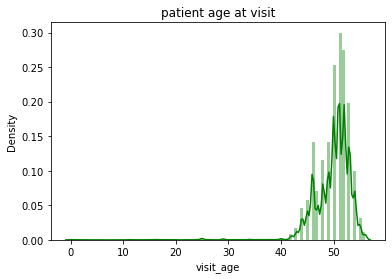

In [144]:
#patient age at visit
av=sns.distplot(df6['visit_age'], color='g', bins=100, hist_kws={'alpha': 0.4})
av.set(title='patient age at visit')

According to the histogram of patients' age at visit, we see a peak around 52-53 and a trailing tail to the left. Indicating that most of the patients visited when they are about 50, which matches our selection criteria.

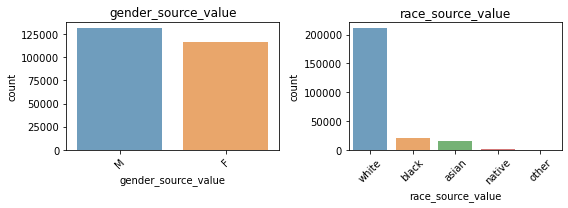

In [151]:
# gender and race bar plot 
cat_col = ['gender_source_value', 'race_source_value']
df_cat = df6[cat_col]

# create figures and plots
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

for i, ax in enumerate(fig.axes):
    if i < len(df_cat.columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.countplot(x=df_cat.columns[i], alpha=0.7, data=df_cat, ax=ax).set(title=cat_col[i])
        

fig.tight_layout()

According to the bar plot of gender and race, we see that there is a close to even distribution of male and female in the data, but mostly white patients. 

[Text(0.5, 1.0, 'patient visit length')]

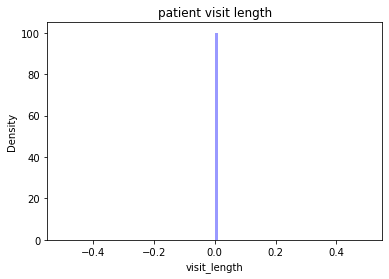

In [146]:
#visit length
vl=sns.distplot(df6['visit_length'], color='b', bins=100, hist_kws={'alpha': 0.4})
vl.set(title='patient visit length')

According to the histogram of pateints visit length, it seems like all the patients completed their visit in one day, probably due to the set up of this dataset. This is usually not what is observed in real data.

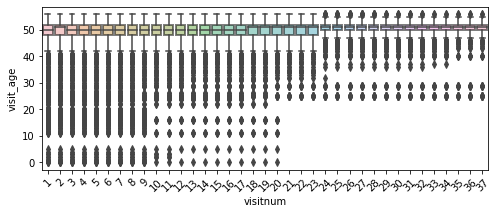

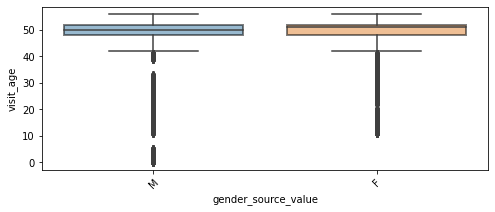

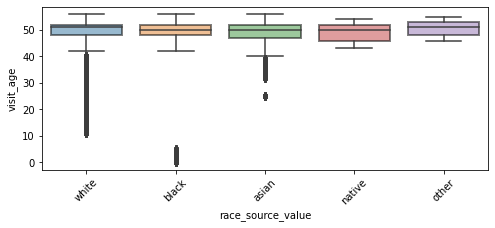

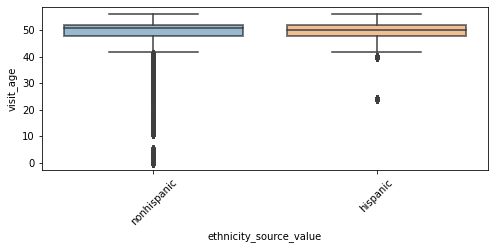

In [167]:
# plot of patient age at visit across categories (box plots)
cat_col2 = ['visitnum', 'gender_source_value', 'race_source_value', 'ethnicity_source_value']
for cat in cat_col2:
    plt.figure(figsize = (10, 6))
    ax = sns.boxplot(x=cat, y="visit_age", data=df6)
    plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
    plt.xticks(rotation=45)

According to the boxlopts for visit number, we see across all visit numbers, the visit age mostly spans within 48 to 52, and a sharp increase from visit number 17 to 18 in the median for visit age, and from visit number 23 to 24 we see a sudden narrowing of the quantiles, with the increase of the lower 25%; this observation matches our intuition that older patients are more likely to visit the hosptital more often. In the graph for gender, we see simiar 25 and 75% quantile ranges but female has a higher median. In the plot for race, we see other and asian has the largest variance in the middle 50%, probbily due to the lack of data in this two race, we also observe a trailing tail ffrom 0 to 10 in black patients, suggesting higher child hospitalization. In the ethnic plot, the range for the two groups are pretty similar, but the non-hispanic group has a longer trailing tail, suggest more variation.

# Short Answer Questions:

In [ ]:
omop_concept.info()

concept: the concept table does not have entry for patient id, but it contains information on the concepts mentioned in the CONDITION_OCCURRENCE and MEASUREMENT tables. We get the concept name in the concept table to occurances tables and then match to patient id.
person:
The person table is the very first table and it is where we store the aggregated information of each patient, in this table we use patient id to connect to, merger with, and source from other tables. Patient id is the first column and  an important element of the person table.
measurement: measurement table is where we store the measurement data in. Patient id is also the first column of the measurement table, and it is through patient id, we can connect the testing informations to the patients' data.

Q: Is race a significnat modifier of visit age in patients from 52 to 56? To solve this question, we could fit a regression model on race and visit age while control for other covariates.  

# Output data

In [195]:
list(df6.columns)

['person_id',
 'gender_concept_id',
 'gender_source_value',
 'birth_datetime',
 'race_source_value',
 'ethnicity_source_value',
 'current_age',
 'visit_occurrence_id',
 'visit_concept_id',
 'visit_start_date',
 'visit_start_datetime',
 'visit_end_date',
 'visit_end_datetime',
 'visit_type_concept_id',
 'visit_length',
 'visit_age',
 'measurement_id',
 'measurement_concept_id',
 'measurement_date',
 'measurement_datetime',
 'measurement_time',
 'measurement_type_concept_id',
 'operator_concept_id',
 'value_as_number',
 'value_as_concept_id',
 'unit_concept_id',
 'range_low',
 'range_high',
 'provider_id_x',
 'visit_detail_id_x',
 'measurement_source_value',
 'measurement_source_concept_id',
 'unit_source_value',
 'unit_source_concept_id',
 'value_source_value',
 'measurement_event_id',
 'meas_event_field_concept_id',
 'concept_id_x',
 'concept_name_x',
 'visitnum',
 'condition_occurrence_id',
 'condition_concept_id',
 'condition_start_date',
 'condition_start_datetime',
 'condition_end_

In [174]:
df6.columns.get_loc("measurement_id")

16

In [175]:
df6.columns.get_loc("concept_name_y")

55

In [196]:
df7=df6.drop(df6.iloc[:, 16:55].columns, axis=1)
list(df7.columns)

['person_id',
 'gender_concept_id',
 'gender_source_value',
 'birth_datetime',
 'race_source_value',
 'ethnicity_source_value',
 'current_age',
 'visit_occurrence_id',
 'visit_concept_id',
 'visit_start_date',
 'visit_start_datetime',
 'visit_end_date',
 'visit_end_datetime',
 'visit_type_concept_id',
 'visit_length',
 'visit_age',
 'concept_name_y',
 'hypertension_condition',
 'diabetes_condition',
 'Respiratory rate',
 'Diastolic blood pressure',
 'Body mass index (BMI) [Percentile] Per age and sex',
 'Body weight',
 'Pain severity - 0-10 verbal numeric rating [Score] - Reported',
 'Heart rate',
 'Body height',
 'Systolic blood pressure',
 'Body mass index (BMI) [Ratio]',
 'Platelet distribution width [Entitic volume] in Blood by Automated count',
 'Leukocytes [#/volume] in Blood by Automated count',
 'Platelet mean volume [Entitic volume] in Blood by Automated count',
 'Erythrocyte distribution width [Entitic volume] by Automated count',
 'Hemoglobin [Mass/volume] in Blood',
 'Hemat

In [197]:
df7.columns.get_loc("gender_source_value")

2

In [198]:
df7.columns.get_loc("visit_start_date")

9

In [202]:
df8=df7.drop(df6.iloc[:,2:9].columns, axis=1)
list(df8.columns)

['person_id',
 'gender_concept_id',
 'visit_start_date',
 'visit_start_datetime',
 'visit_end_date',
 'visit_end_datetime',
 'visit_type_concept_id',
 'visit_length',
 'visit_age',
 'concept_name_y',
 'hypertension_condition',
 'diabetes_condition',
 'Respiratory rate',
 'Diastolic blood pressure',
 'Body mass index (BMI) [Percentile] Per age and sex',
 'Body weight',
 'Pain severity - 0-10 verbal numeric rating [Score] - Reported',
 'Heart rate',
 'Body height',
 'Systolic blood pressure',
 'Body mass index (BMI) [Ratio]',
 'Platelet distribution width [Entitic volume] in Blood by Automated count',
 'Leukocytes [#/volume] in Blood by Automated count',
 'Platelet mean volume [Entitic volume] in Blood by Automated count',
 'Erythrocyte distribution width [Entitic volume] by Automated count',
 'Hemoglobin [Mass/volume] in Blood',
 'Hematocrit [Volume Fraction] of Blood by Automated count',
 'MCH [Entitic mass] by Automated count',
 'Erythrocytes [#/volume] in Blood by Automated count',
 

In [203]:
df8.columns.get_loc("visit_start_datetime")

3

In [204]:
df8.columns.get_loc("visit_type_concept_id")

6

In [205]:
df9=df8.drop(df8.iloc[:,3:6].columns, axis=1)
list(df9.columns)

['person_id',
 'gender_concept_id',
 'visit_start_date',
 'visit_type_concept_id',
 'visit_length',
 'visit_age',
 'concept_name_y',
 'hypertension_condition',
 'diabetes_condition',
 'Respiratory rate',
 'Diastolic blood pressure',
 'Body mass index (BMI) [Percentile] Per age and sex',
 'Body weight',
 'Pain severity - 0-10 verbal numeric rating [Score] - Reported',
 'Heart rate',
 'Body height',
 'Systolic blood pressure',
 'Body mass index (BMI) [Ratio]',
 'Platelet distribution width [Entitic volume] in Blood by Automated count',
 'Leukocytes [#/volume] in Blood by Automated count',
 'Platelet mean volume [Entitic volume] in Blood by Automated count',
 'Erythrocyte distribution width [Entitic volume] by Automated count',
 'Hemoglobin [Mass/volume] in Blood',
 'Hematocrit [Volume Fraction] of Blood by Automated count',
 'MCH [Entitic mass] by Automated count',
 'Erythrocytes [#/volume] in Blood by Automated count',
 'MCV [Entitic volume] by Automated count',
 'Platelets [#/volume] i

In [206]:
final=df9.drop(['visit_type_concept_id', 'concept_name_y'], axis=1)
final.head()

,person_id,gender_concept_id,visit_start_date,visit_length,visit_age,hypertension_condition,diabetes_condition,Respiratory rate,Diastolic blood pressure,Body mass index (BMI) [Percentile] Per age and sex,...,INR in Platelet poor plasma by Coagulation assay,Lymph nodes with micrometastases [#] in Cancer specimen by Light microscopy,Basophils [#/volume] in Blood by Automated count,Prothrombin time (PT),Lymphocytes/100 leukocytes in Blood by Automated count,Lymphocytes [#/volume] in Blood by Automated count,Neutrophils [#/volume] in Blood by Automated count,Monocytes [#/volume] in Blood by Automated count,Neutrophils/100 leukocytes in Blood by Automated count,Fibrin D-dimer FEU [Mass/volume] in Platelet poor plasma
3213,12,8507,2012-11-28,0,44,absence,absence,15.0,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3214,12,8507,2012-11-28,0,44,absence,absence,NA,108.0,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3215,12,8507,2012-11-28,0,44,absence,absence,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3216,12,8507,2012-11-28,0,44,absence,absence,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3217,12,8507,2012-11-28,0,44,absence,absence,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [209]:
final.to_csv('/Users/hengjianli/Desktop/dat.csv',index=False)